<a href="https://colab.research.google.com/github/babaroscopy/Thesis/blob/main/Thesis_RegionProposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Region Proposal Algorithm
> Object Detection using Region Proposal Algorithm

- toc: true 
- badges: true
- comments: true
- categories: [Keras, CNN, OpenCV]
- image: images/chart-preview.png

In [ ]:
import tensorflow as tf
import numpy as np
import argparse
import cv2
print(tf.__version__)
print(cv2.__version__)
import matplotlib.pyplot as plt
import time
from imutils.object_detection import non_max_suppression

2.11.0
4.6.0


## 1. HGFHDGFHG
RPA generates in an image regions based on superpixels custering algorithms. 

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default =  "/content/0.jpg", required = False,
    help="path to the input image")
ap.add_argument("-m", "--method", type=str, default="fast",
    choices=["fast", "quality"],
    help="selective search method")
ap.add_argument("-c", "--conf", type=float, default=0.7,
    help="minimum probability to consider a classification/detection")
ap.add_argument("-f", "--filter", type=str, default=None,
    help="comma separated list of ImageNet labels to filter on")
args = vars(ap.parse_args([]))

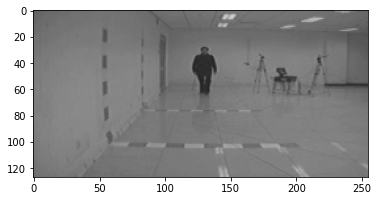

In [ ]:
labelFilters = args["filter"]

image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
w = 255
scale = w/(image.shape[1])
h = int(scale * image.shape[0])
image = cv2.resize(image, (w, h))
plt.imshow(image)
(H, W) = image.shape[:2]

In [ ]:
#collapse-hide
# initialize OpenCV's selective search implementation and set the
# input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

# check to see if we are using the *fast* but *less accurate* version
# of selective search
if args["method"] == "fast":
    print("[INFO] using *fast* selective search")
    ss.switchToSelectiveSearchFast()

# otherwise we are using the *slower* but *more accurate* version
else:
    print("[INFO] using *quality* selective search")
    ss.switchToSelectiveSearchQuality()

# run selective search on the input image

[INFO] using *fast* selective search


In [ ]:
# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))

# loop over the region proposals in chunks (so we can better
# visualize them)
for i in range(0, len(rects), 100):
    # clone the original image so we can draw on it
    output = image.copy()

    # loop over the current subset of region proposals
    for (x, y, w, h) in rects[i:i + 100]:
        # draw the region proposal bounding box on the image
        color = [np.random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

    # show the output image
    #cv2.imshow("Output", output) #plt.imshow("selectiveSearch.jpg") #cv2.imshow("Output", output)
    #key = cv2.waitKey(0) & 0xFF

    # if the `q` key was pressed, break from the loop
    #if key == ord("q"):
        #break

[INFO] selective search took 0.3146 seconds
[INFO] 83 total region proposals


In [ ]:
model = tf.keras.applications.ResNet50(weights = "imagenet", include_top = True)

102967424/102967424 [==============================] - 4s 0us/step


In [ ]:
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
    # if the width or height of the region is less than 10% of the
    # image width or height, ignore it (i.e., filter out small
    # objects that are likely false-positives)
    if w / float(W) < 0.1 or h / float(H) < 0.1:
        continue
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to 224x224 (the input
    # dimensions required by our pre-trained CNN)
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224, 224))
    # further preprocess by the ROI
    roi = tf.keras.preprocessing.image.img_to_array(roi)
    roi = tf.keras.applications.resnet50.preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, w, h))    

In [ ]:
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))
print("[INFO] proposal number: {}".format(len(proposals)))
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=1)
# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

[INFO] proposal shape: (39, 224, 224, 3)
[INFO] proposal number: 39
[INFO] classifying proposals...
35363/35363 [==============================] - 0s 0us/step


In [ ]:
preds[15:30][0]

[('n02916936', 'bulletproof_vest', 0.19501156)]

In [ ]:
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current region proposal
    (imagenetID, label, prob) = p[0]
    # only if the label filters are not empty *and* the label does not
    # exist in the list, then ignore it
    if labelFilters is not None and label not in labelFilters:
        continue
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= args["conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        (x, y, w, h) = boxes[i]
        box = (x, y, x + w, y + h)
        # grab the list of predictions for the label and add the
        # bounding box + probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

[INFO] showing results for 'parallel_bars'
[INFO] showing results for 'horizontal_bar'
[INFO] showing results for 'tripod'


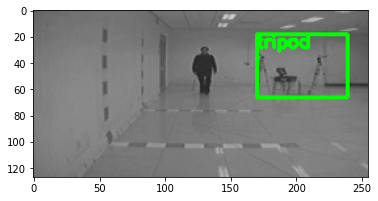

In [ ]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = image.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #cv2.imshow("Before", clone)
    plt.imshow(clone)
    plt.savefig("/content/0.jpg")
    clone = image.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.savefig("/content/1.jpg")

[INFO] showing results for 'parallel_bars'
[INFO] showing results for 'horizontal_bar'
[INFO] showing results for 'tripod'


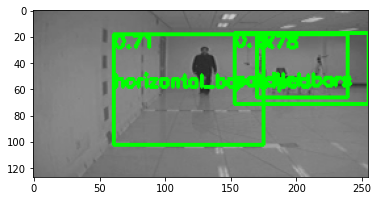

In [ ]:
allclone = image.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = image.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = image.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)        
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.imsave("/content/0"+ "a" + label + ".jpg", clone) 
plt.imshow(allclone)
plt.imsave("/content/0" + "b" + ".jpg", allclone)     
    #plt.imshow(clone)
    #plt.imsave("images/_res03.jpg", clone)
    #cv2.imshow("After", clone)
    #cv2.waitKey(0)    

## References

> https://www.pyimagesearch.com/2020/07/06/region-proposal-object-detection-with-opencv-keras-and-tensorflow/